# Project 3: Statistics

This is the technical notebook for Mod3. <br>
It summarizes and contains the highlights of the work done. <br>
Source: https://crime-data-explorer.fr.cloud.gov/api <br>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

import crime_helper as ch

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', -1)

## Data From API

### Get Lookup Data

In [3]:
# first load the lookup tables (state, region, offenses, etc), to be used in further api calls

state_ls = ch.get_json(ch.LOOKUP_STATES)
len(state_ls)
state_ls[0]

{'count': 58, 'page': 0, 'pages': 3, 'per_page': 20}
page 0: len 20
page 1: len 20
page 2: len 18


58

{'state_id': 1,
 'state_name': 'Alaska',
 'state_abbr': 'AK',
 'region_code': 4,
 'state_fips_code': 2}

In [4]:
# use a dataframe to inspect the results

state_df = pd.DataFrame(state_ls)
state_df.head()
state_df.info()

,region_code,state_abbr,state_fips_code,state_id,state_name
0,4,AK,2.0,1,Alaska
1,3,AL,1.0,2,Alabama
2,3,AR,5.0,3,Arkansas
3,99,AS,60.0,4,American Samoa
4,4,AZ,4.0,5,Arizona


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 5 columns):
region_code        58 non-null int64
state_abbr         58 non-null object
state_fips_code    57 non-null float64
state_id           58 non-null int64
state_name         58 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 2.3+ KB


In [5]:
# export the lookup table to a file

save_path = r'data/lookup_state.csv'
state_df.to_csv(save_path, index=False)
f'{round(os.path.getsize(save_path) /1e3, 2)} kb'

'1.37 kb'

In [6]:
# also load the offenses-short file, which was created by hand from the dropdown on the API documentation

OFFENSE_SHORT = 'data/lookup_offense_short.csv'
offense_df = pd.read_csv(OFFENSE_SHORT)
offense_df.head()

,offense_type
0,aggravated-assault
1,burglary
2,larceny
3,motor-vehicle-theft
4,homicide


### Get Crime Data from Endpoints

In [7]:
# loop over all lookup values for the specific endpooints and aggregate all the results

offense_ls = []

for idx_off, row_off in offense_df.iterrows():
    offense = row_off['offense_type']
    print(offense)
    
    for idx_stt, row_stt in state_df.iterrows():
        state = row_stt['state_abbr']
        
        config = {
            '{offense}': offense,
            '{stateAbbr}': state,
        }
        offense_result = ch.get_json(ch.OFFENSE_STATE, config)
        
        for res in offense_result['data']:
            new_dx = {
                'state': state,
                'offense': offense,
                'year': res['data_year'],
                'count': res['value'],
            }
            offense_ls.append(new_dx)
            
offense_ls[:5]

aggravated-assault
burglary
larceny
motor-vehicle-theft
homicide
rape
robbery
arson
violent-crime
property-crime


[{'state': 'AL',
  'offense': 'aggravated-assault',
  'year': 1991,
  'count': 21909},
 {'state': 'AL',
  'offense': 'aggravated-assault',
  'year': 1992,
  'count': 17637},
 {'state': 'AL', 'offense': 'aggravated-assault', 'year': 2006, 'count': 30},
 {'state': 'AL', 'offense': 'aggravated-assault', 'year': 2007, 'count': 31},
 {'state': 'AL', 'offense': 'aggravated-assault', 'year': 2008, 'count': 32}]

In [8]:
# create dataframe to process the endpoint data

offense_df = pd.DataFrame(offense_ls)
offense_df = offense_df[['state', 'year', 'offense', 'count']]
offense_df = offense_df.sort_values(['state', 'year', 'offense'])
offense_df.head()
offense_df.info()

,state,year,offense,count
0,AL,1991,aggravated-assault,21909
15,AL,1991,aggravated-assault,21909
10238,AL,1991,arson,92
10252,AL,1991,arson,92
1474,AL,1991,burglary,47915


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14646 entries, 0 to 13151
Data columns (total 4 columns):
state      14646 non-null object
year       14646 non-null int64
offense    14646 non-null object
count      14646 non-null int64
dtypes: int64(2), object(2)
memory usage: 572.1+ KB


In [9]:
# not sure why the api returns duplicate rows

doop_df = offense_df.loc[offense_df.duplicated(subset=['state', 'year', 'offense'], keep=False) == True]
doop_df.head()

,state,year,offense,count
0,AL,1991,aggravated-assault,21909
15,AL,1991,aggravated-assault,21909
10238,AL,1991,arson,92
10252,AL,1991,arson,92
1474,AL,1991,burglary,47915


In [10]:
offense_df = offense_df.drop_duplicates(subset=['state', 'year', 'offense'])
offense_df = offense_df.reset_index()
offense_df = offense_df[['state', 'year', 'offense', 'count']]
offense_df.head()
offense_df.info()

,state,year,offense,count
0,AL,1991,aggravated-assault,21909
1,AL,1991,arson,92
2,AL,1991,burglary,47915
3,AL,1991,homicide,434
4,AL,1991,larceny,107142


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7323 entries, 0 to 7322
Data columns (total 4 columns):
state      7323 non-null object
year       7323 non-null int64
offense    7323 non-null object
count      7323 non-null int64
dtypes: int64(2), object(2)
memory usage: 228.9+ KB


In [11]:
# export endpoint results to csv 

save_path = r'data/offense_tkm_state.csv'
offense_df.to_csv(save_path, index=False)
f'{round(os.path.getsize(save_path) /1e6, 2)} mb'

'0.18 mb'

### Prepare data for all endpoints

In [12]:
# once all endpoints are run, can load data from respective csv

ARREST_FILE = 'data/arrest_tkm_state.csv'
EMPLOYMENT_FILE = 'data/employment_state.csv'
OFFENDER_FILE = 'data/offender_tkm_state.csv'
OFFENSE_FILE = 'data/offense_tkm_state.csv'
VICTIM_FILE = 'data/victim_tkm_state.csv'

AGENCY_FILE = 'data/lookup_state.csv'
STATE_FILE = 'data/lookup_state.csv'
REGION_FILE = 'data/lookup_region.csv'
OFFENSE_SHORT = 'data/lookup_offense_short.csv'
OFFENSE_MEDIUM = 'data/lookup_offense_medium.csv'

# Arrests per Population Analysis - Phillip

## Load Region Data

In [13]:
region_df = pd.read_csv(REGION_FILE)
region_df

,region_code,region_desc,region_name
0,0,U.S. Territories,U.S. Territories
1,1,Region I,Northeast
2,2,Region II,Midwest
3,3,Region III,South
4,4,Region IV,West
5,99,Other,Other


In [14]:
state_full_df = pd.merge(state_df, region_df, how='inner', on='region_code')
state_clean_df = state_full_df.sort_values('state_abbr').reset_index()
state_clean_df = state_clean_df[['state_abbr', 'state_name', 'region_code', 'region_name']]
state_clean_df.head(10)
state_clean_df.info()

,state_abbr,state_name,region_code,region_name
0,AK,Alaska,4,West
1,AL,Alabama,3,South
2,AR,Arkansas,3,South
3,AS,American Samoa,99,Other
4,AZ,Arizona,4,West
5,CA,California,4,West
6,CO,Colorado,4,West
7,CT,Connecticut,1,Northeast
8,CZ,Canal Zone,99,Other
9,DC,District of Columbia,3,South


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 4 columns):
state_abbr     58 non-null object
state_name     58 non-null object
region_code    58 non-null int64
region_name    58 non-null object
dtypes: int64(1), object(3)
memory usage: 1.9+ KB


## Load & Clean Arrests

In [15]:
arrest_df = pd.read_csv(ARREST_FILE)
arrest_df = arrest_df.rename(columns={'count': 'arrests'})
arrest_df.head()
arrest_df.info()

,state,year,gender,offense,arrests
0,AK,2000,female,aggravated-assault,194
1,AK,2000,female,arson,3
2,AK,2000,female,burglary,49
3,AK,2000,female,curfew,1
4,AK,2000,female,disorderly-conduct,221


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51102 entries, 0 to 51101
Data columns (total 5 columns):
state      51102 non-null object
year       51102 non-null int64
gender     51102 non-null object
offense    51102 non-null object
arrests    51102 non-null int64
dtypes: int64(2), object(3)
memory usage: 1.9+ MB


In [16]:
# group the data to get rid of gender and offense column 

arrest_total_df = arrest_df.groupby(['state', 'year']).sum().sort_values(['state', 'year'])
arrest_total_df = arrest_total_df.reset_index()
arrest_total_df.head()
arrest_total_df.info()

,state,year,arrests
0,AK,2000,21354
1,AK,2001,20267
2,AK,2002,19818
3,AK,2003,22746
4,AK,2004,21027


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 3 columns):
state      952 non-null object
year       952 non-null int64
arrests    952 non-null int64
dtypes: int64(2), object(1)
memory usage: 22.4+ KB


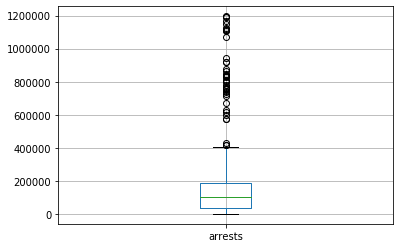

In [17]:
# examine the arrest data

arrest_total_df.boxplot(column=['arrests'])

## Load Employment for Population

In [18]:
employment_df = pd.read_csv(EMPLOYMENT_FILE)
employment_df.head()
employment_df.info()

,agency_ct,civilian_ct,year,female_civilian_ct,female_officer_ct,female_total_ct,male_civilian_ct,male_officer_ct,male_total_ct,pe_ct_per_1000,population,state_abbr,state_name,total_pe_ct
0,32,675.0,2000,475.0,103.0,578.0,200.0,1055.0,1255.0,2.92,626932,AK,Alaska,1833.0
1,33,661.0,2001,463.0,107.0,570.0,198.0,1097.0,1295.0,2.94,634892,AK,Alaska,1865.0
2,33,701.0,2002,482.0,112.0,594.0,219.0,1091.0,1310.0,2.96,643893,AK,Alaska,1904.0
3,33,682.0,2003,470.0,111.0,581.0,212.0,1063.0,1275.0,2.86,648921,AK,Alaska,1856.0
4,34,688.0,2004,470.0,127.0,597.0,218.0,1125.0,1343.0,2.96,655932,AK,Alaska,1940.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969 entries, 0 to 968
Data columns (total 14 columns):
agency_ct             969 non-null int64
civilian_ct           969 non-null float64
year                  969 non-null int64
female_civilian_ct    969 non-null float64
female_officer_ct     969 non-null float64
female_total_ct       969 non-null float64
male_civilian_ct      969 non-null float64
male_officer_ct       969 non-null float64
male_total_ct         969 non-null float64
pe_ct_per_1000        969 non-null float64
population            969 non-null int64
state_abbr            969 non-null object
state_name            969 non-null object
total_pe_ct           969 non-null float64
dtypes: float64(9), int64(3), object(2)
memory usage: 106.1+ KB


In [19]:
# keep only the necessary columns

population_df = employment_df[['state_abbr', 'year', 'population']]
population_df.head()

,state_abbr,year,population
0,AK,2000,626932
1,AK,2001,634892
2,AK,2002,643893
3,AK,2003,648921
4,AK,2004,655932


In [20]:
# confirm that there are the expected number of states per year

population_df.groupby('year').count()

,state_abbr,population
year,,
2000,51,51
2001,51,51
2002,51,51
2003,51,51
2004,51,51
2005,51,51
2006,51,51
2007,51,51
2008,51,51


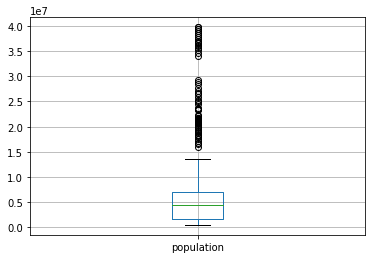

In [21]:
# visualize the data

population_df.boxplot(column='population')

## Merge Arrests and Population Data

In [22]:
# merge arrests and employment data

merge_1_df = pd.merge(arrest_total_df, population_df, how='inner', 
                      left_on=['state', 'year'], right_on=['state_abbr', 'year'])
merge_1_df.head()
merge_1_df.shape

,state,year,arrests,state_abbr,population
0,AK,2000,21354,AK,626932
1,AK,2001,20267,AK,634892
2,AK,2002,19818,AK,643893
3,AK,2003,22746,AK,648921
4,AK,2004,21027,AK,655932


(949, 5)

In [23]:
# merge the region information to group by regions later

merge_2_df = pd.merge(merge_1_df, state_clean_df, how='inner', left_on=['state'], right_on=['state_abbr'])
merge_2_df.head()

,state,year,arrests,state_abbr_x,population,state_abbr_y,state_name,region_code,region_name
0,AK,2000,21354,AK,626932,AK,Alaska,4,West
1,AK,2001,20267,AK,634892,AK,Alaska,4,West
2,AK,2002,19818,AK,643893,AK,Alaska,4,West
3,AK,2003,22746,AK,648921,AK,Alaska,4,West
4,AK,2004,21027,AK,655932,AK,Alaska,4,West


In [24]:
# keep only columns that will be used

merge_df = merge_2_df[['region_name', 'state', 'year', 'arrests', 'population']]
merge_df.head()
merge_df.shape

,region_name,state,year,arrests,population
0,West,AK,2000,21354,626932
1,West,AK,2001,20267,634892
2,West,AK,2002,19818,643893
3,West,AK,2003,22746,648921
4,West,AK,2004,21027,655932


(949, 5)

## Analyze & Clean the Merged Data

In [25]:
merge_df['arrest_popu'] = round(merge_df['arrests'] / merge_df['population'], 6)
merge_df.head()
merge_df.info()

/Users/philbert/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,region_name,state,year,arrests,population,arrest_popu
0,West,AK,2000,21354,626932,0.034061
1,West,AK,2001,20267,634892,0.031922
2,West,AK,2002,19818,643893,0.030778
3,West,AK,2003,22746,648921,0.035052
4,West,AK,2004,21027,655932,0.032057


<class 'pandas.core.frame.DataFrame'>
Int64Index: 949 entries, 0 to 948
Data columns (total 6 columns):
region_name    949 non-null object
state          949 non-null object
year           949 non-null int64
arrests        949 non-null int64
population     949 non-null int64
arrest_popu    949 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 51.9+ KB


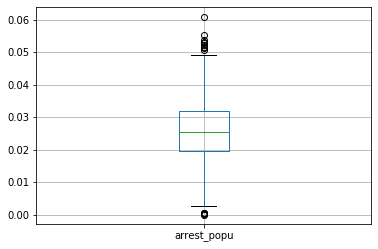

In [26]:
merge_df.boxplot(column=['arrest_popu'])

(923, 6)

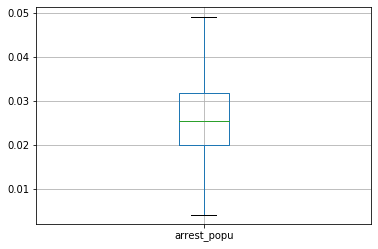

In [27]:
# throw out anomalous data

merge_filter_df = merge_df.loc[merge_df['arrest_popu'].between(0.004, 0.05)]
merge_filter_df.shape
merge_filter_df.boxplot(column=['arrest_popu'])

In [28]:
# not much data was cut out 

merge_filter_df.groupby(['year']).count()[['state']]

,state
year,
2000,47
2001,49
2002,48
2003,49
2004,49
2005,49
2006,49
2007,48
2008,48


## Create Region Series

In [29]:
# midwest

region_MW_df = merge_filter_df.loc[merge_filter_df['region_name']=='Midwest']
region_MW_sr = region_MW_df['arrest_popu']
region_MW_sr.shape

(220,)

In [30]:
# northeast

region_NE_df = merge_filter_df.loc[merge_filter_df['region_name']=='Northeast']
region_NE_sr = region_NE_df['arrest_popu']
region_NE_sr.shape

(171,)

In [31]:
# west

region_WT_df = merge_filter_df.loc[merge_filter_df['region_name']=='West']
region_WT_sr = region_WT_df['arrest_popu']
region_WT_sr.shape

(244,)

In [32]:
# south 

region_ST_df = merge_filter_df.loc[merge_filter_df['region_name']=='South']
region_ST_sr = region_ST_df['arrest_popu']
region_ST_sr.shape

(288,)

## Check the Region Distributions

In [33]:
# test for normal distribution of the samples
# extras / sampling distributions .ipynb

k, p = stats.normaltest(region_MW_sr)
p_MW = round(p, 4)

k, p = stats.normaltest(region_NE_sr)
p_NE = round(p, 4)

k, p = stats.normaltest(region_WT_sr)
p_WT = round(p, 4)

k, p = stats.normaltest(region_ST_sr)
p_ST = round(p, 4)

print(f'midwest: {p_MW}')
print(f'northeast: {p_NE}')
print(f'west: {p_WT}')
print(f'south: {p_ST}')

midwest: 0.001
northeast: 0.0001
west: 0.4885
south: 0.0352


[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Arrests/Population'),
 Text(0.5, 1.0, 'Midwest')]

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Arrests/Population'),
 Text(0.5, 1.0, 'Northeast')]

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Arrests/Population'),
 Text(0.5, 1.0, 'West')]

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Arrests/Population'),
 Text(0.5, 1.0, 'South')]

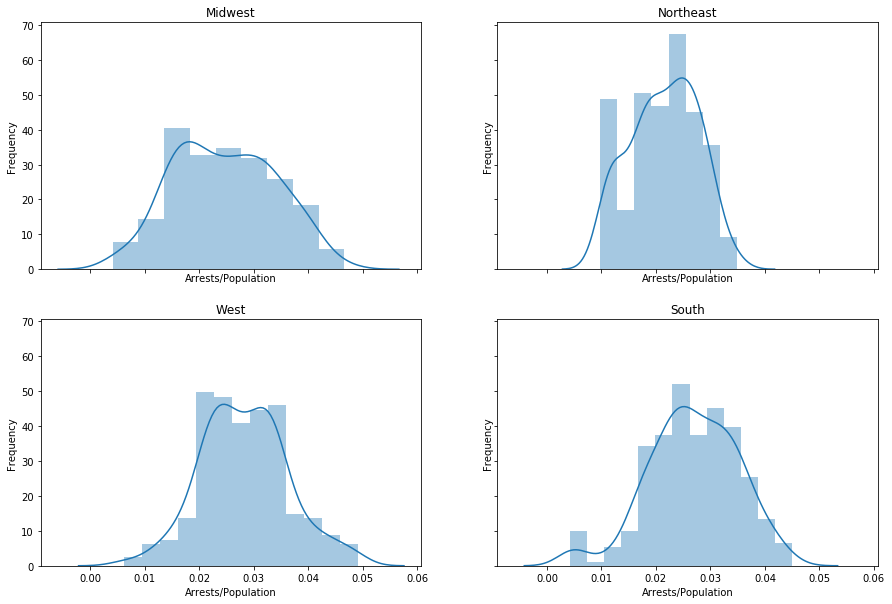

In [34]:
# plot the distributions

fig, axs = plt.subplots(2,2, figsize=(15, 10), sharey=True, sharex=True)

sns.distplot(region_MW_sr, ax=axs[0][0])
axs[0][0].set(xlabel='Arrests/Population', ylabel='Frequency', title='Midwest')
#ax1.set_xticklabels(labels=df_genre_cnt_plot.index, rotation=90)

sns.distplot(region_NE_sr, ax=axs[0][1])
axs[0][1].set(xlabel='Arrests/Population', ylabel='Frequency', title='Northeast')

sns.distplot(region_WT_sr, ax=axs[1][0])
axs[1][0].set(xlabel='Arrests/Population', ylabel='Frequency', title='West')

sns.distplot(region_ST_sr, ax=axs[1][1])
axs[1][1].set(xlabel='Arrests/Population', ylabel='Frequency', title='South')

plt.show()

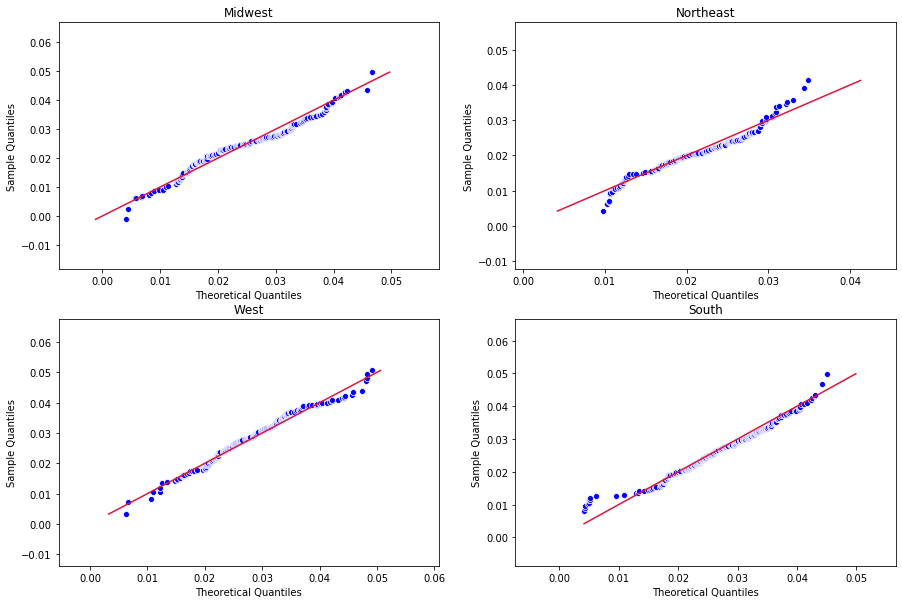

In [35]:
# examine the qqplots for regions

def seaborn_qqplot(data_ls, axis, title):
    
    # create theoretical uantile dataframe and plot it
    
    normal_ls = np.random.normal(data_ls.mean(), data_ls.std(), data_ls.shape[0])
    percs = np.linspace(0, 100, data_ls.shape[0])
    
    quantile_normal = np.percentile(normal_ls, percs)
    quantile_data = np.percentile(data_ls, percs)
    plot_df = pd.DataFrame({'y': quantile_normal, 'x': quantile_data})
    
    sns.scatterplot(y='y', x='x', data=plot_df, ax=axis, color='blue')
    
    # plot fit line
    
    line_ls = np.linspace(np.min((quantile_normal.min(),quantile_data.min())), 
                          np.max((quantile_normal.max(),quantile_data.max())))
    line_df = pd.DataFrame({'y': line_ls, 'x': line_ls})
    
    sns.lineplot(y='y', x='x', data=line_df, ax=axis, color='crimson', dashes=True)
    
    #sns.distplot(normal_ls, color='red', ax=axis)
    #sns.distplot(data_ls, color='blue', ax=axis)
    
    axis.set(ylabel='Sample Quantiles', xlabel='Theoretical Quantiles', title=title)
    
    
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

seaborn_qqplot(region_MW_sr, axs[0][0], 'Midwest')
seaborn_qqplot(region_NE_sr, axs[0][1], 'Northeast')
seaborn_qqplot(region_WT_sr, axs[1][0], 'West')
seaborn_qqplot(region_ST_sr, axs[1][1], 'South')

## Run Analysis

In [36]:
# run anova test

stats.f_oneway(region_MW_sr, region_NE_sr, region_WT_sr, region_ST_sr)

F_onewayResult(statistic=27.00258123927213, pvalue=9.669407599272442e-17)

In [37]:
# run welch's test to differentiate regions

k, p = stats.ttest_ind(region_MW_sr, region_NE_sr)
p_MW_NE = round(p, 8)

k, p = stats.ttest_ind(region_MW_sr, region_WT_sr)
p_MW_WT = round(p, 8)

k, p = stats.ttest_ind(region_MW_sr, region_ST_sr)
p_MW_ST = round(p, 8)

k, p = stats.ttest_ind(region_NE_sr, region_WT_sr)
p_NE_WT = round(p, 8)

k, p = stats.ttest_ind(region_NE_sr, region_ST_sr)
p_NE_ST = round(p, 8)

k, p = stats.ttest_ind(region_WT_sr, region_ST_sr)
p_WT_ST = round(p, 8)

print(f'midwest, northeast: {p_MW_NE}')
print(f'midwest, west: {p_MW_WT}')
print(f'midwest, south: {p_MW_ST}')
print(f'northeast, west: {p_NE_WT}')
print(f'northeast, south: {p_NE_ST}')
print(f'west, south: {p_WT_ST}')

midwest, northeast: 0.00012819
midwest, west: 7.75e-06
midwest, south: 0.0057939
northeast, west: 0.0
northeast, south: 0.0
west, south: 0.03622847


# Hypothesis testing on demographical features

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


Importing the specifically created files for cleaning and merging

In [3]:
import datamerge

### Retrieving data for the project

In [4]:
#creating dataframe from csv files
offender_df = pd.read_csv('data/offender_race_state.csv')
employment_df = pd.read_csv('data/employment_state.csv')
victim_df = pd.read_csv('data/victim_tkm_state.csv')
race_ratio_df = pd.read_excel('data/Population_byrace_bystate.xlsx')

The source of the ethnicity data: 2017 1-year American Community Survey estimates, U.S. Census Bureau, retrieved from: https://www.governing.com/gov-data/census/state-minority-population-data-estimates.html

In [11]:
#creating a population table
population_df = datamerge.create_population_df(employment_df, race_ratio_df)

In [6]:
population_df.head(2)
offender_df.head(2)

,state,year,race,offense,offenders
0,AL,2010,Asian,aggravated-assault,0
1,AL,2011,Asian,aggravated-assault,0


In [7]:
#table for visualisation
table = offender_df.loc[offender_df.year == 2018].groupby('race').offenders.sum().reset_index()
table

,race,offenders
0,American Indian or Alaska Native,44984
1,Asian,31612
2,Black or African American,1162774
3,Native Hawaiian,0
4,Unknown,1168656
5,White,2013720


In [10]:
offender_df = datamerge.create_offender_df(offender_df, population_df)

KeyError: 'race'